In [1]:
%pylab inline
import tensorflow as tf
import skimage
import logging
import gc
import os
import dataset
logging.basicConfig(level=logging.DEBUG)

Populating the interactive namespace from numpy and matplotlib


In [2]:
# Load data
data = dataset.Dataset.load('PLCO2')
# train_data = dataset.Dataset.load('PLCO_train')
# test_data = dataset.Dataset.load('PLCO_test')

INFO:dataset:Loaded PLCO2 dataset with 9536 features.


The following functions provide a utility wrapper around commonly used layers.

In [3]:
def weight_variable(shape, name):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial, name=name)

def bias_variable(shape, name):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial, name=name)

def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                        strides=[1, 2, 2, 1], padding='SAME')

In [4]:
# Input data from training.
x = tf.placeholder(tf.float32, shape=[None, 256*256], name='data')
y_ = tf.placeholder(tf.float32, shape=[None, 2], name='label')

In [5]:
# Reshape as four-dimensional tensor
with tf.name_scope('reshape_data'):
    x_image = tf.reshape(x, [-1, 256, 256, 1])
    tf.summary.image('example_images', x_image)

In [6]:
# First convolutional-ReLU-pooling layer
with tf.name_scope('conv1'):
    W_conv1 = weight_variable([5, 5, 1, 32], 'W_conv1')
    b_conv1 = bias_variable([32], 'b_conv1')
    h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)
    h_pool1 = max_pool_2x2(h_conv1)
h_pool1

<tf.Tensor 'conv1/MaxPool:0' shape=(?, 128, 128, 32) dtype=float32>

In [7]:
with tf.name_scope('conv2'):
    W_conv2 = weight_variable([5, 5, 32, 64], 'W_conv2')
    b_conv2 = bias_variable([64], 'b_conv2')
    h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
    h_pool2 = max_pool_2x2(h_conv2)
h_pool2

<tf.Tensor 'conv2/MaxPool:0' shape=(?, 64, 64, 64) dtype=float32>

In [8]:
# Generate a visualization of the parameters learned from the second layer.
V = tf.slice(h_pool2,(0,0,0,0),(1,-1,-1,-1)) #V[0,...]
V = tf.reshape(V,(64,64,64)) # width: 64, height: 64, out_params: 64
V = tf.reshape(V,(64,64,8,8)) # 64 parameters -> 8 rows x 8 cols
V = tf.transpose(V,(2,0,3,1)) #cy,iy,cx,ix
V = tf.reshape(V,(1,8*64,8*64,1))
tf.summary.image('SecondConvolutionLayer', V)

<tf.Tensor 'SecondConvolutionLayer:0' shape=() dtype=string>

In [9]:
with tf.name_scope('conv3'):
    W_conv3 = weight_variable([5, 5, 64, 128], 'W_conv3')
    b_conv3 = bias_variable([128], 'b_conv3')
    h_conv3 = tf.nn.relu(conv2d(h_pool2, W_conv3) + b_conv3)
    h_pool3 = max_pool_2x2(h_conv3)
h_pool3

<tf.Tensor 'conv3/MaxPool:0' shape=(?, 32, 32, 128) dtype=float32>

In [10]:
with tf.name_scope('conv4'):
    W_conv4 = weight_variable([5, 5, 128, 256], 'W_conv4')
    b_conv4 = bias_variable([256], 'b_conv4')
    h_conv4 = tf.nn.relu(conv2d(h_pool3, W_conv4) + b_conv4)
    h_pool4 = max_pool_2x2(h_conv4)
h_pool4

<tf.Tensor 'conv4/MaxPool:0' shape=(?, 16, 16, 256) dtype=float32>

In [11]:
with tf.name_scope('conv5'):
    W_conv5 = weight_variable([5, 5, 256, 512], 'W_conv5')
    b_conv5 = bias_variable([512], 'b_conv5')
    h_conv5 = tf.nn.relu(conv2d(h_pool4, W_conv5) + b_conv5)
    h_pool5 = max_pool_2x2(h_conv5)
h_pool5

<tf.Tensor 'conv5/MaxPool:0' shape=(?, 8, 8, 512) dtype=float32>

In [12]:
# First fully-connected layer with ReLU.
with tf.name_scope('fc1'):
    W_fc1 = weight_variable([8 ** 2 * 512, 1024], 'W_fc1')
    b_fc1 = bias_variable([1024], 'b_fc1')
    h_pool5_flat = tf.reshape(h_pool5, [-1, 8 ** 2 * 512])
    h_fc1 = tf.nn.relu(tf.matmul(h_pool5_flat, W_fc1) + b_fc1)
h_fc1

<tf.Tensor 'fc1/Relu:0' shape=(?, 1024) dtype=float32>

In [13]:
# Second fully-connected layer with dropout to reduce overfitting.
with tf.name_scope('dropout'):
    keep_prob = tf.placeholder(tf.float32)
    h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)
    W_fc2 = weight_variable([1024, 2], 'W_fc2')
    b_fc2 = bias_variable([2], 'b_fc2')

tf.summary.histogram('W_fc2_hist', W_fc2)
tf.summary.histogram('b_fc2_hist', b_fc2)

with tf.name_scope('softmax'):
    y_conv = tf.matmul(h_fc1_drop, W_fc2) + b_fc2

In [14]:
# Logits cross-entropy used to improve numerical stability
with tf.name_scope('cross_entropy'):
    diff = tf.nn.softmax_cross_entropy_with_logits(logits=y_conv, labels=y_)
    with tf.name_scope('total'):
        cross_entropy = tf.reduce_mean(diff)
tf.summary.scalar('cross_entropy', cross_entropy)

<tf.Tensor 'cross_entropy_1:0' shape=() dtype=string>

In [15]:
# Adam optimizer. Implementation of gradient descent.
with tf.name_scope('train'):
    train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)

In [16]:
# Calculate accuracy of model by comparing output (y_conv) to ground truth (y_)
with tf.name_scope('accuracy'):
    with tf.name_scope('correct_prediction'):
        correct_prediction = tf.equal(tf.argmax(y_conv, 1), tf.argmax(y_, 1))
    with tf.name_scope('accuracy'):
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
tf.summary.scalar('accuracy', accuracy)

<tf.Tensor 'accuracy_1:0' shape=() dtype=string>

In [17]:
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))

In [18]:
merged = tf.summary.merge_all()

train_writer = tf.summary.FileWriter('train', sess.graph)
test_writer = tf.summary.FileWriter('test')

tf.global_variables_initializer().run(session=sess)

saver = tf.train.Saver()

In [19]:
epochs = 1
train_loader = data.batch()
test_loader = train_loader
iterations = train_loader.features_train.shape[0] // 16 * int(epochs)
print('Iterations to train: {}'.format(iterations))

for i in range(iterations):
    batch = train_loader.next_batch(16)
    if i % 10 == 0:
        # Calculate the accuracy on the validation set.
        feed_dict = {x: test_loader.test['images'][:100], y_: test_loader.test['labels'][:100], keep_prob: 1.0}
        summary, acc = sess.run([merged, accuracy], feed_dict=feed_dict)
        test_writer.add_summary(summary, i)
        test_writer.flush()
        print('Accuracy at step %s: %s' % (i, acc))
    else:
        # Train on the training set.
        feed_dict = {x:batch[0], y_: batch[1], keep_prob: 0.5}
        summary, _ = sess.run([merged, train_step], feed_dict=feed_dict)
        train_writer.add_summary(summary, i)
        train_writer.flush()
    if i % 1000 == 0:
        saver.save(sess, 'plco-model', global_step=i)


INFO:dataset:Using 6567 features for training and 2189 features for testing.


Iterations to train: 410
Accuracy at step 0: 0.51
Accuracy at step 10: 0.51
Accuracy at step 20: 0.49
Accuracy at step 30: 0.51
Accuracy at step 40: 0.51
Accuracy at step 50: 0.64
Accuracy at step 60: 0.77
Accuracy at step 70: 0.93
Accuracy at step 80: 0.93
Accuracy at step 90: 0.93
Accuracy at step 100: 0.94
Accuracy at step 110: 0.93
Accuracy at step 120: 0.93
Accuracy at step 130: 0.93
Accuracy at step 140: 0.93
Accuracy at step 150: 0.92
Accuracy at step 160: 0.92
Accuracy at step 170: 0.93
Accuracy at step 180: 0.93
Accuracy at step 190: 0.94
Accuracy at step 200: 0.77
Accuracy at step 210: 0.94
Accuracy at step 220: 0.94
Accuracy at step 230: 0.93
Accuracy at step 240: 0.94
Accuracy at step 250: 0.93
Accuracy at step 260: 0.94
Accuracy at step 270: 0.93
Accuracy at step 280: 0.93
Accuracy at step 290: 0.93
Accuracy at step 300: 0.94
Accuracy at step 310: 0.94
Accuracy at step 320: 0.93
Accuracy at step 330: 0.92
Accuracy at step 340: 0.94
Accuracy at step 350: 0.94
Accuracy at st

In [20]:
train_writer.close()
test_writer.close()

In [21]:
print("Done")

Done


In [22]:
batch = data.batch()

INFO:dataset:Using 6567 features for training and 2189 features for testing.


In [23]:
%timeit sess.run(accuracy, feed_dict={x: batch.test['images'][:1], y_: batch.test['labels'][:1], keep_prob: 1.0})

The slowest run took 19.01 times longer than the fastest. This could mean that an intermediate result is being cached.
1 loop, best of 3: 12.2 ms per loop


In [24]:
prob = tf.nn.softmax(y_conv)

In [25]:
prob.eval(feed_dict={x: batch.test['images'][:1], keep_prob: 1.0}, session=sess)

array([[ 0.,  1.]], dtype=float32)

In [26]:
healthy = [batch.test['images'][index] for index, lbl in enumerate(batch.test['labels']) if lbl[0] == 1.]
cancer = [batch.test['images'][index] for index, lbl in enumerate(batch.test['labels']) if lbl[1] == 1.]
print('Healthy: {}, cancer: {}'.format(len(healthy), len(cancer)))

Healthy: 1085, cancer: 1104


In [27]:
random.shuffle(healthy)
random.shuffle(cancer)

In [28]:
healthy_res = []
cancer_res = []

# Run feed forward over the entire validation set in 100-image batches

for i in range(0, len(healthy), 100):
    batch = healthy[i:i+100]
    rt = prob.eval(feed_dict={x: batch, keep_prob: 1.0}, session=sess)
    for row in rt:
        healthy_res.append(row)
        
for i in range(0, len(cancer), 100):
    batch = cancer[i:i+100]
    rt = prob.eval(feed_dict={x: batch, keep_prob: 1.0}, session=sess)
    for row in rt:
        cancer_res.append(row)

In [29]:
import csv
with open('evaluation.csv', 'w') as csvfile:
    fieldnames = ['gt', 'pred']
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
    
    writer.writeheader()
    for i in range(len(healthy)):
        writer.writerow({'gt': 0, 'pred': 0 if healthy_res[i][0] > 0.5 else 1})
    for i in range(len(cancer)):
        writer.writerow({'gt': 1, 'pred': 0 if cancer_res[i][0] > 0.5 else 1})

In [30]:
cancer_prob = cancer_res/sum(cancer_res, axis=1)[:,None]
cancer_idx = sorted(range(len(cancer)), key=lambda idx: 1 if cancer_prob[idx][1] < 0.9 else cancer_prob[idx][1])

healthy_prob = healthy_res/sum(healthy_res, axis=1)[:,None]
healthy_idx = sorted(range(len(healthy)), key=lambda idx: 1 if healthy_prob[idx][0] < 0.9 else healthy_prob[idx][0])

In [31]:
healthy_sample = list(map(lambda idx: healthy[idx], healthy_idx[:4]))
cancer_sample = list(map(lambda idx: cancer[idx], cancer_idx[:4]))

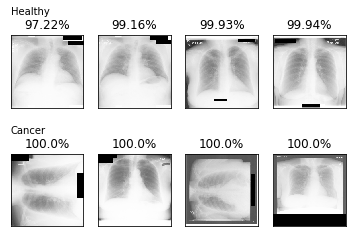

In [32]:
fig = plt.figure()

for idx, img in enumerate(healthy_sample):
    ax = fig.add_subplot(2, 4, idx+1)
    if idx == 0:
        text(0, -70, 'Healthy')
    f = plt.imshow(img.reshape((256, 256)), cmap=cm.gray)
    f.axes.get_xaxis().set_visible(False)
    f.axes.get_yaxis().set_visible(False)
    pred = healthy_prob[healthy_idx[idx]]
    ax.set_title(str(pred[0] * 100)[:5] + '%')
    
for idx, img in enumerate(cancer_sample):
    ax = fig.add_subplot(2, 4, idx+5)
    if idx == 0:
        text(0, -70, 'Cancer')
    f = plt.imshow(img.reshape((256, 256)), cmap=cm.gray)
    f.axes.get_xaxis().set_visible(False)
    f.axes.get_yaxis().set_visible(False)
    pred = cancer_prob[cancer_idx[idx]]
    ax.set_title(str(pred[1] * 100)[:5] + '%')